In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import transforms, datasets
import os

# -----------------------
# Data Preparation & Preprocessing
# -----------------------

""" 
In this section, we define the transformations applied to the images before they are fed into the model. 
The images are resized to 256x256 pixels, converted to tensors, and normalized to have pixel values in the range of [-1, 1]. 
This normalization is important for GANs as it helps stabilize the training process.
"""
transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

"""
The datasets for both faces and sketches are loaded using the ImageFolder method, which organizes the images into directories 
based on their class labels. The resulting datasets are then passed into DataLoader instances, which handle batching and shuffling 
of the data during training.
"""
face_dataset = datasets.ImageFolder("/kaggle/input/person-face-sketches/faces", transform=transform)
sketch_dataset = datasets.ImageFolder("/kaggle/input/person-face-sketches/sketches", transform=transform)

batch_size = 300  
face_loader = DataLoader(face_dataset, batch_size=batch_size, shuffle=True)
sketch_loader = DataLoader(sketch_dataset, batch_size=batch_size, shuffle=True)

# -----------------------
# CycleGAN Architecture
# -----------------------

""" 
Here, we define the architecture of the CycleGAN, which consists of two generators and two discriminators. 
The generator class is designed to transform images from one domain to another (e.g., from face to sketch and vice versa). 
It includes an encoder for downsampling and a decoder for upsampling the images back to their original size. 
The output of the generator is passed through a Tanh activation function to ensure that the output values fall within the range [-1, 1].
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  
            nn.Tanh()  
        )

    def forward(self, x):
        encoded = self.encoder(x)  
        decoded = self.decoder(encoded)  
        return decoded

"""
The Discriminator class is designed to distinguish between real and fake images for both the face and sketch domains. 
It processes the input images through several convolutional layers, applying LeakyReLU activations and batch normalization. 
The final output is a probability score that indicates whether the input image is real or generated, achieved using a Sigmoid activation function.
"""
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=1),  
            nn.Sigmoid()  
        )

    def forward(self, x):
        return self.model(x)

"""
The cycle_consistency_loss function calculates the cycle-consistency loss between the real images and their reconstructed versions. 
This loss is crucial for ensuring that the generators are able to transform images back and forth accurately between the two domains. 
It uses the L1 norm to measure the absolute difference between the real and reconstructed images, scaled by a weight parameter.
"""
def cycle_consistency_loss(real_image, reconstructed_image, lambda_weight):
    return lambda_weight * torch.mean(torch.abs(real_image - reconstructed_image))

# -----------------------
# Model Initialization
# -----------------------

"""
In this section, we initialize the generators and discriminators for both image domains. 
The two generators (G and F) will learn to map images from the face domain to the sketch domain and vice versa. 
Similarly, the two discriminators (D_Face and D_Sketch) will learn to differentiate between real and fake images in their respective domains.
"""
G = Generator()  
F = Generator()  
D_Face = Discriminator()  
D_Sketch = Discriminator()  

"""
We set up optimizers for all models using the Adam optimization algorithm, which will update the parameters of the models during training. 
The learning rate is set to 0.0002 with specific beta values to control the decay rates of the moving averages.
"""
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
F_optimizer = optim.Adam(F.parameters(), lr=lr, betas=(0.5, 0.999))
D_Face_optimizer = optim.Adam(D_Face.parameters(), lr=lr, betas=(0.5, 0.999))
D_Sketch_optimizer = optim.Adam(D_Sketch.parameters(), lr=lr, betas=(0.5, 0.999))

"""
We define the adversarial_loss function using binary cross-entropy loss, which will be used to train the discriminators by comparing 
their predictions against the ground truth labels (real or fake). This helps the model learn to classify images accurately.
"""
adversarial_loss = nn.BCELoss()

# -----------------------
# Training CycleGAN
# -----------------------

""" 
In this section, we set the training parameters, including the number of epochs, the weight for the cycle-consistency loss, 
and the directory where generated images will be saved. We ensure that the output directory exists before starting the training process.
"""
num_epochs = 200  
lambda_cycle = 10.0  
save_dir = "./cycle_gan_output"  
os.makedirs(save_dir, exist_ok=True)  

"""
The main training loop iterates over the specified number of epochs, processing batches of real face and sketch images. 
During each epoch, we train the discriminators and generators sequentially. The discriminators are trained first to improve their 
ability to distinguish between real and fake images, followed by the generators, which learn to produce images that the discriminators 
classify as real.
"""
for epoch in range(num_epochs):
    for i, (real_faces, real_sketches) in enumerate(zip(face_loader, sketch_loader)):
        real_faces = real_faces[0]  
        real_sketches = real_sketches[0]  

        # ---------------------
        #  Train Discriminators
        # ---------------------

        """ 
        The first step involves generating fake faces from real sketches using the F generator. 
        We compute the discriminator loss for real and fake face images, averaging these losses to update D_Face.
        """
        fake_faces = F(real_sketches)
        
        real_loss_D_Face = adversarial_loss(D_Face(real_faces), torch.ones_like(D_Face(real_faces)))
        fake_loss_D_Face = adversarial_loss(D_Face(fake_faces.detach()), torch.zeros_like(D_Face(fake_faces)))
        D_Face_loss = (real_loss_D_Face + fake_loss_D_Face) / 2

        D_Face_optimizer.zero_grad()  
        D_Face_loss.backward()  
        D_Face_optimizer.step()  

        """ 
        Next, we generate fake sketches from real faces using the G generator. 
        The discriminator loss for sketches is calculated in a similar manner, allowing us to update D_Sketch.
        """
        fake_sketches = G(real_faces)

        real_loss_D_Sketch = adversarial_loss(D_Sketch(real_sketches), torch.ones_like(D_Sketch(real_sketches)))
        fake_loss_D_Sketch = adversarial_loss(D_Sketch(fake_sketches.detach()), torch.zeros_like(D_Sketch(fake_sketches)))
        D_Sketch_loss = (real_loss_D_Sketch + fake_loss_D_Sketch) / 2

        D_Sketch_optimizer.zero_grad()  
        D_Sketch_loss.backward()  
        D_Sketch_optimizer.step()  

        # -----------------
        #  Train Generators
        # -----------------
        
        """ 
        The next step is to train the generators. We first calculate the cycle-consistency loss for face images 
        transformed to sketches and then back to faces. This ensures that the generated images remain consistent 
        with the original inputs. 
        """
        reconstructed_faces = F(G(real_faces))
        cycle_loss_face = cycle_consistency_loss(real_faces, reconstructed_faces, lambda_cycle)

        """ 
        Similarly, we compute the cycle-consistency loss for sketches transformed to faces and back to sketches.
        """
        reconstructed_sketches = G(F(real_sketches))
        cycle_loss_sketch = cycle_consistency_loss(real_sketches, reconstructed_sketches, lambda_cycle)

        """ 
        The total generator loss for G is computed by summing the adversarial loss from D_Sketch and the cycle-consistency loss for sketches. 
        The same is done for F, where the adversarial loss comes from D_Face and the cycle-consistency loss is for faces.
        """
        G_loss = adversarial_loss(D_Sketch(fake_sketches), torch.ones_like(D_Sketch(fake_sketches))) + cycle_loss_sketch

        F_loss = adversarial_loss(D_Face(fake_faces), torch.ones_like(D_Face(fake_faces))) + cycle_loss_face

        """ 
        We then perform backpropagation for both generators to update their parameters, ensuring they learn from the losses calculated.
        """
        G_optimizer.zero_grad()  
        G_loss.backward()  
        G_optimizer.step()  

        F_optimizer.zero_grad()  
        F_loss.backward()  
        F_optimizer.step()  

    """ 
    After each epoch, we print the losses for the discriminators and generators. 
    This helps in monitoring the training progress and evaluating the performance of the models over time.
    """
    print(f"Epoch [{epoch}/{num_epochs}], D_Face Loss: {D_Face_loss.item()}, D_Sketch Loss: {D_Sketch_loss.item()}, G Loss: {G_loss.item()}, F Loss: {F_loss.item()}")

    """ 
    Additionally, we save generated images every 10 epochs to visualize the progress of the generators. 
    The images are stored in the specified output directory with names indicating the epoch.
    """
    if (epoch + 1) % 10 == 0:
        save_image(fake_faces, os.path.join(save_dir, f'fake_faces_epoch_{epoch + 1}.png'))
        save_image(fake_sketches, os.path.join(save_dir, f'fake_sketches_epoch_{epoch + 1}.png'))

    """ 
    Finally, we save the generator models after the 4th epoch, allowing us to retain the state of the models 
    at that point in the training process for potential further training or evaluation.
    """
    if epoch == 4:
        torch.save(G.state_dict(), 'generator_ab_epoch_4.pth')  
        torch.save(F.state_dict(), 'generator_ba_epoch_4.pth')  

# End of training loop


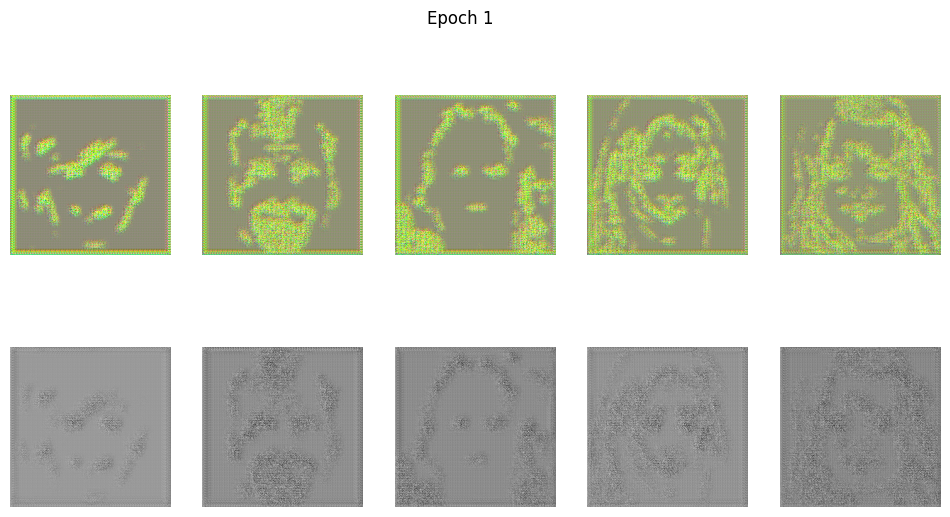

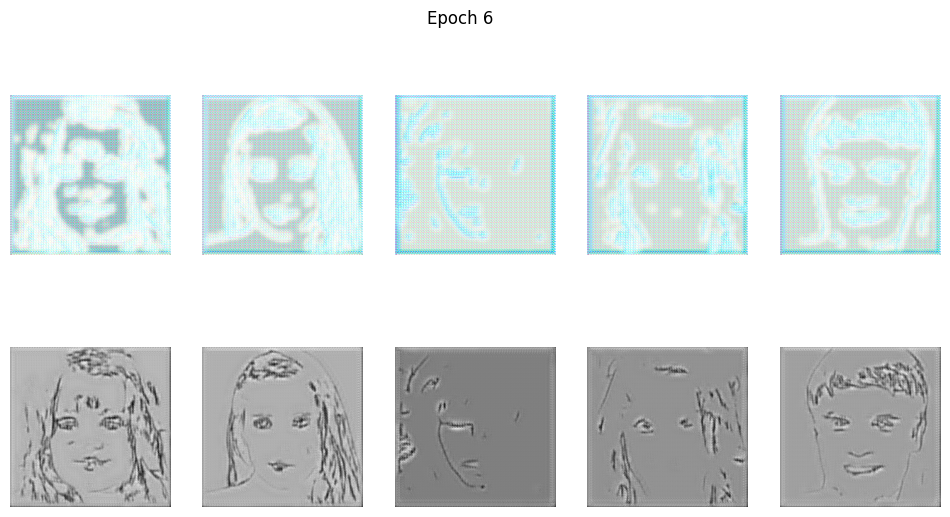

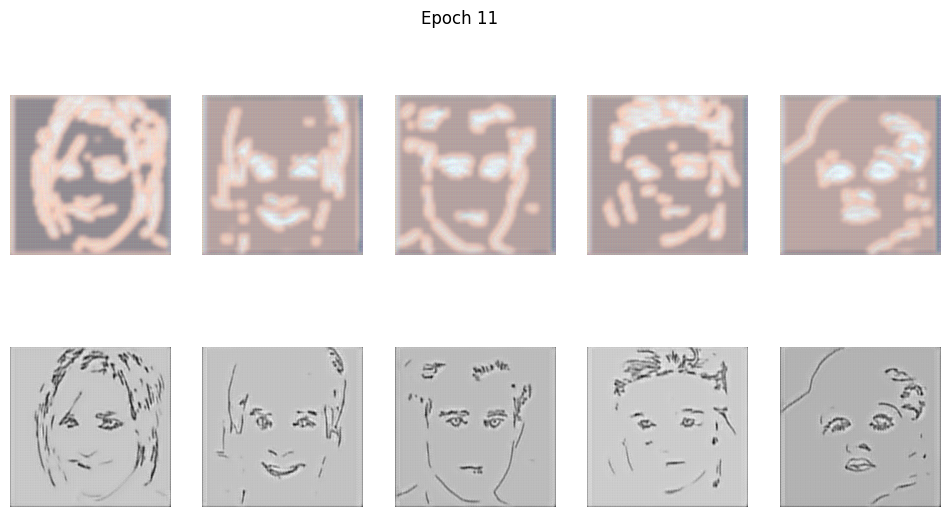

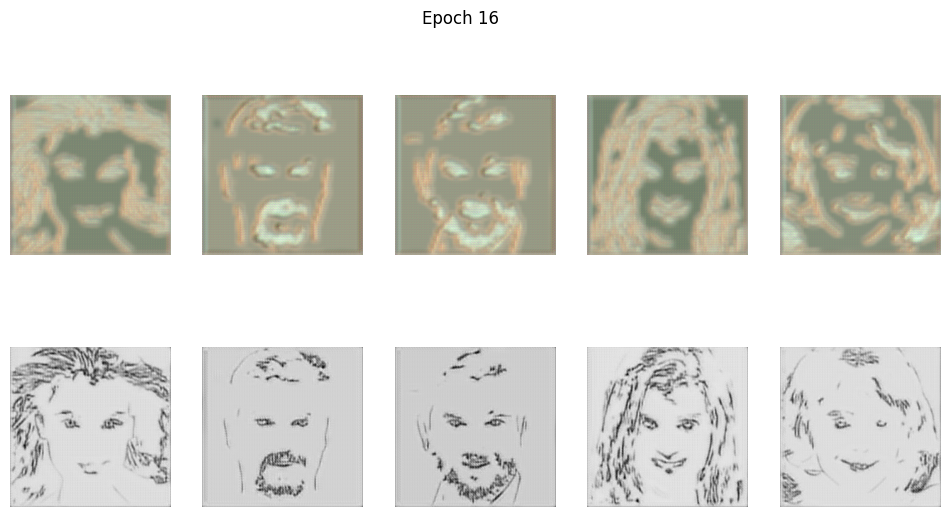

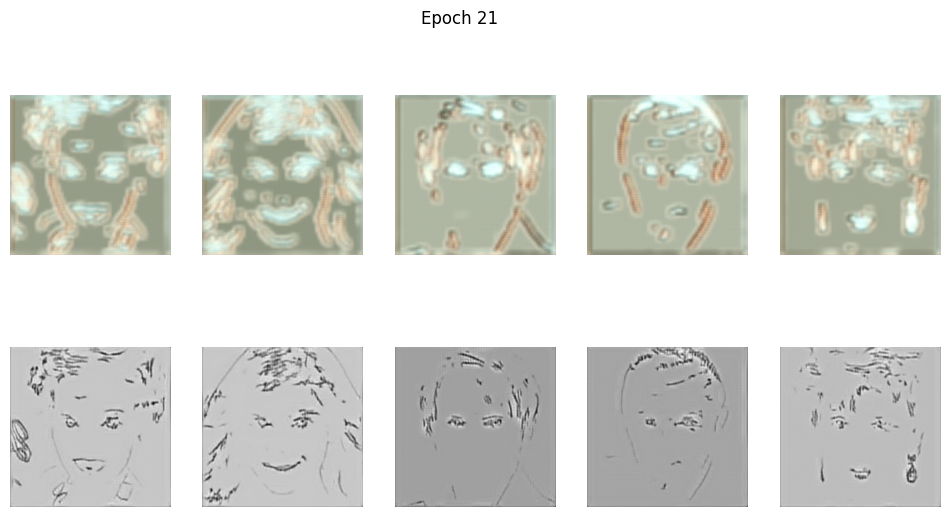

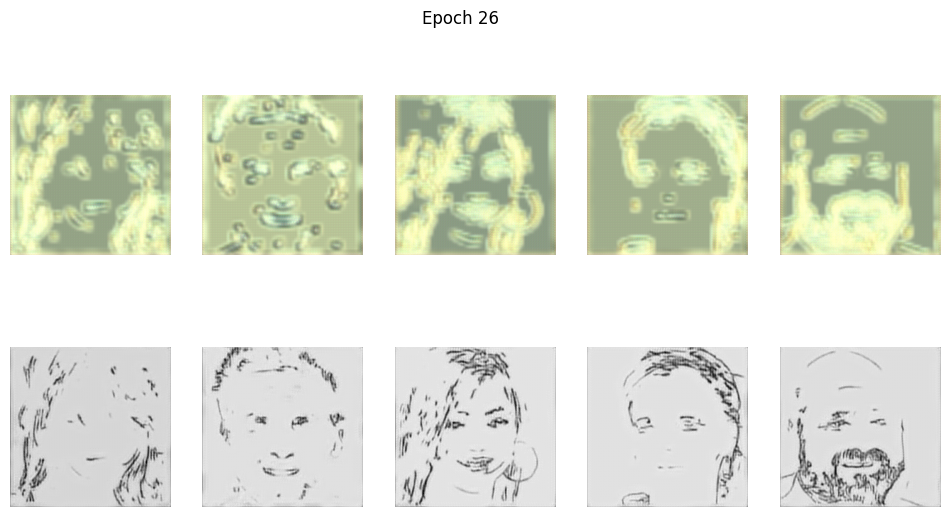

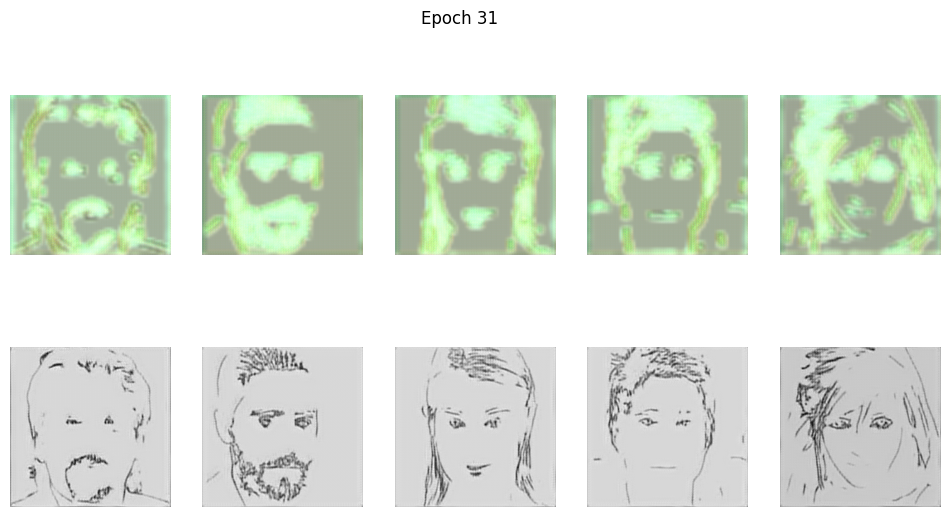

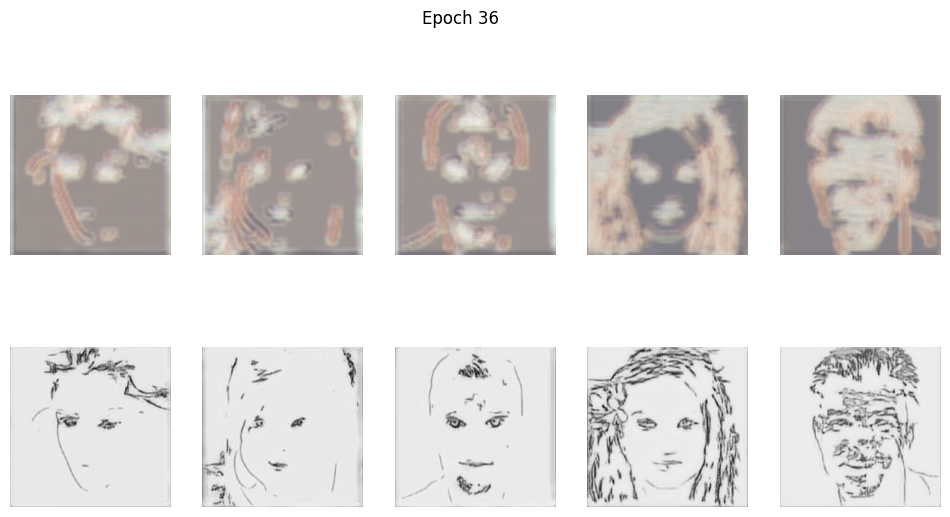

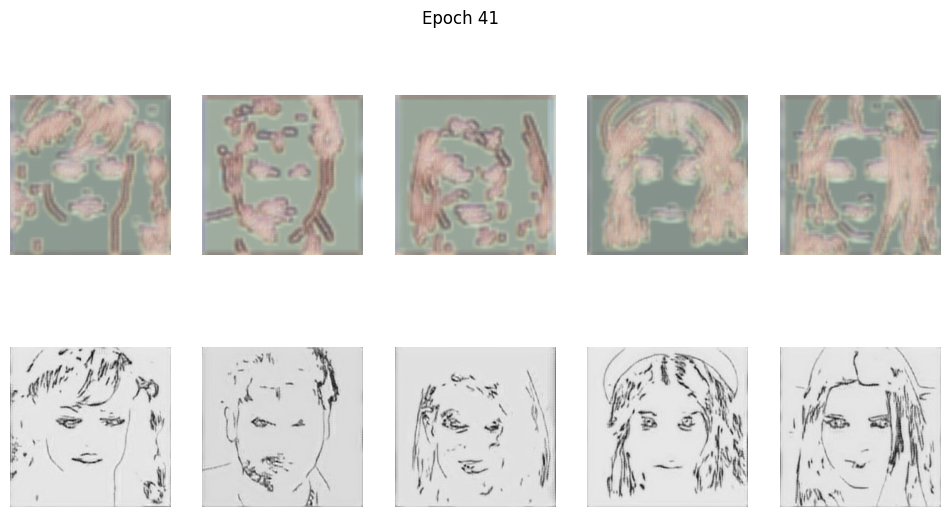

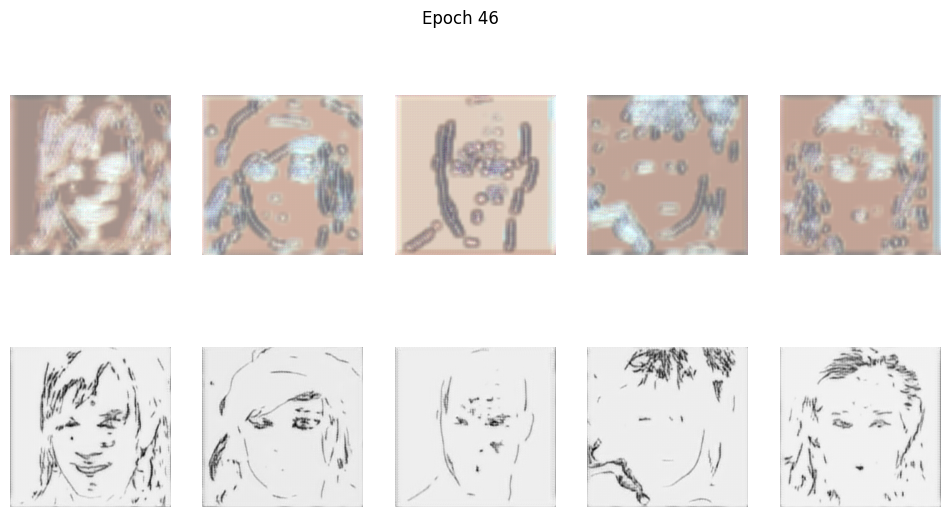